In [91]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import multiprocessing
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
def load_expanded():
    return pd.read_pickle('nyc-2017-yellow-taxi-trips-to-airport-expanded.pkl.gz')

%time df_exp = load_expanded()

CPU times: user 453 ms, sys: 172 ms, total: 625 ms
Wall time: 628 ms


In [5]:
df_exp.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509468 entries, 14 to 113496861
Data columns (total 12 columns):
pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
pickup_borough           category
pickup_zone              category
pickup_service_zone      category
dropoff_zone             category
dropoff_month            category
drop_off_week_of_year    category
dropoff_day_of_year      category
dropoff_day_of_month     category
dropoff_hour             category
trip_duration_minutes    float64
dtypes: category(9), datetime64[ns](2), float64(1)
memory usage: 102.9 MB


In [6]:
def load_one_hot_encoded():
        return pd.read_pickle('nyc-2017-yellow-taxi-trips-to-airport-one-hot-encoded.pkl.gz')

%time df_ohe = load_one_hot_encoded()

CPU times: user 4.03 s, sys: 2.88 s, total: 6.91 s
Wall time: 6.91 s


In [7]:
df_ohe.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509468 entries, 14 to 113496861
Columns: 744 entries, pickup_borough_Bronx to dropoff_hour_23
dtypes: uint8(744)
memory usage: 1.8 GB


In [8]:
df = pd.concat([df_exp, df_ohe], axis=1)

In [9]:
df.head()

,pickup_datetime,dropoff_datetime,pickup_borough,pickup_zone,pickup_service_zone,dropoff_zone,dropoff_month,drop_off_week_of_year,dropoff_day_of_year,dropoff_day_of_month,...,dropoff_hour_14,dropoff_hour_15,dropoff_hour_16,dropoff_hour_17,dropoff_hour_18,dropoff_hour_19,dropoff_hour_20,dropoff_hour_21,dropoff_hour_22,dropoff_hour_23
14,2017-03-28 14:56:33,2017-03-28 16:14:19,Manhattan,Greenwich Village North,Yellow Zone,JFK Airport,3,13,87,28,...,0,0,1,0,0,0,0,0,0,0
18,2017-03-28 14:56:35,2017-03-28 15:50:06,Manhattan,Lenox Hill West,Yellow Zone,JFK Airport,3,13,87,28,...,0,1,0,0,0,0,0,0,0,0
63,2017-03-28 14:56:45,2017-03-28 15:35:29,Manhattan,Central Park,Yellow Zone,LaGuardia Airport,3,13,87,28,...,0,1,0,0,0,0,0,0,0,0
128,2017-03-28 14:57:00,2017-03-28 15:27:54,Manhattan,Garment District,Yellow Zone,LaGuardia Airport,3,13,87,28,...,0,1,0,0,0,0,0,0,0,0
140,2017-03-28 14:57:04,2017-03-28 15:45:30,Manhattan,Murray Hill,Yellow Zone,JFK Airport,3,13,87,28,...,0,1,0,0,0,0,0,0,0,0


In [21]:
df.shape

(2509468, 756)

In [20]:
[c for c in df.columns if c.startswith('pickup_zone_')]

['pickup_zone_Allerton/Pelham Gardens',
 'pickup_zone_Alphabet City',
 'pickup_zone_Arden Heights',
 'pickup_zone_Arrochar/Fort Wadsworth',
 'pickup_zone_Astoria',
 'pickup_zone_Astoria Park',
 'pickup_zone_Auburndale',
 'pickup_zone_Baisley Park',
 'pickup_zone_Bath Beach',
 'pickup_zone_Battery Park',
 'pickup_zone_Battery Park City',
 'pickup_zone_Bay Ridge',
 'pickup_zone_Bay Terrace/Fort Totten',
 'pickup_zone_Bayside',
 'pickup_zone_Bedford',
 'pickup_zone_Bedford Park',
 'pickup_zone_Bellerose',
 'pickup_zone_Belmont',
 'pickup_zone_Bensonhurst East',
 'pickup_zone_Bensonhurst West',
 'pickup_zone_Bloomfield/Emerson Hill',
 'pickup_zone_Bloomingdale',
 'pickup_zone_Boerum Hill',
 'pickup_zone_Borough Park',
 'pickup_zone_Briarwood/Jamaica Hills',
 'pickup_zone_Brighton Beach',
 'pickup_zone_Broad Channel',
 'pickup_zone_Bronx Park',
 'pickup_zone_Bronxdale',
 'pickup_zone_Brooklyn Heights',
 'pickup_zone_Brooklyn Navy Yard',
 'pickup_zone_Brownsville',
 'pickup_zone_Bushwick Nor

# Random Forest Regressor

In [137]:
%time dfs = df.reindex(np.random.permutation(df.index))

CPU times: user 8.59 s, sys: 10.4 s, total: 19 s
Wall time: 8.39 s


In [138]:
def make_dfx_dfy(df):
    dfx = df.drop(columns=['pickup_datetime', 'dropoff_datetime',
                         'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_zone',
                         'dropoff_month', 'drop_off_week_of_year', 'dropoff_day_of_year',
                         'dropoff_day_of_month', 'dropoff_hour',
                        'trip_duration_minutes'])
    dfy = df.trip_duration_minutes
    return dfx,dfy

In [139]:
df1 = df#.query('pickup_zone == "Murray Hill" and dropoff_zone == "Newark Airport"')

In [140]:
df1.shape

(2509468, 756)

In [141]:
dfx,dfy = make_dfx_dfy(df1)

In [48]:
[c for c in dfx.columns if c.startswith('drop')

Index(['pickup_borough_Bronx', 'pickup_borough_Brooklyn', 'pickup_borough_EWR',
       'pickup_borough_Manhattan', 'pickup_borough_Queens',
       'pickup_borough_Staten Island', 'pickup_zone_Allerton/Pelham Gardens',
       'pickup_zone_Alphabet City', 'pickup_zone_Arden Heights',
       'pickup_zone_Arrochar/Fort Wadsworth',
       ...
       'dropoff_hour_14', 'dropoff_hour_15', 'dropoff_hour_16',
       'dropoff_hour_17', 'dropoff_hour_18', 'dropoff_hour_19',
       'dropoff_hour_20', 'dropoff_hour_21', 'dropoff_hour_22',
       'dropoff_hour_23'],
      dtype='object', length=744)

In [142]:
X,y = dfx, dfy

In [143]:
dfx.shape, dfy.shape

((2509468, 744), (2509468,))

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=0)

In [64]:
sample_frac = 0.001

In [70]:
def make_model(n_ests, n_jobs=-1):
    return {
        'forest': RandomForestRegressor(n_estimators=n_ests, bootstrap=True, criterion='mse', random_state=0, n_jobs=n_jobs),
        'n_estimators': n_ests,
    } 

def train_model(m, X_train, y_train, sample_frac):
    if sample_frac < 1.0:
        sample_max_index = int(X.shape[0] * sample_frac)
        m['sample'] = { 'frac': sample_frac, 'max_index': sample_max_index }
        m['forest'].fit(X_train[:sample_max_index], y_train[:sample_max_index])
    else:
        m['forest'].fit(X_train, y_train)
    return m

def score_model(m, X_train, X_test, y_train, y_test):
    y_train_pred = m['forest'].predict(X_train)
    y_test_pred = m['forest'].predict(X_test)
    m['score'] = {
        'mean_absolute_error': {
            'train': mean_absolute_error(y_train, y_train_pred),
            'test': mean_absolute_error(y_test, y_test_pred),
        } 
    }
    return m

def model_name(m):
    return 'forest-ests-{}'.format(m['n_estimators'])

def do_model(n, X_train, X_test, y_train, y_test, sample_frac=1):
    m = make_model(n_ests=n)
    m = train_model(m, X_train, y_train, sample_frac)
    m = score_model(m, X_train, X_test, y_train, y_test)
    
    file_name = model_name(m) + '.pickle.gz'
    pd.to_pickle(m, file_name)
    
    return m
 

In [77]:
mae_baseline = np.mean(np.abs(y - y.mean()))
mae_baseline

18.62056737800137

<BarContainer object of 743 artists>

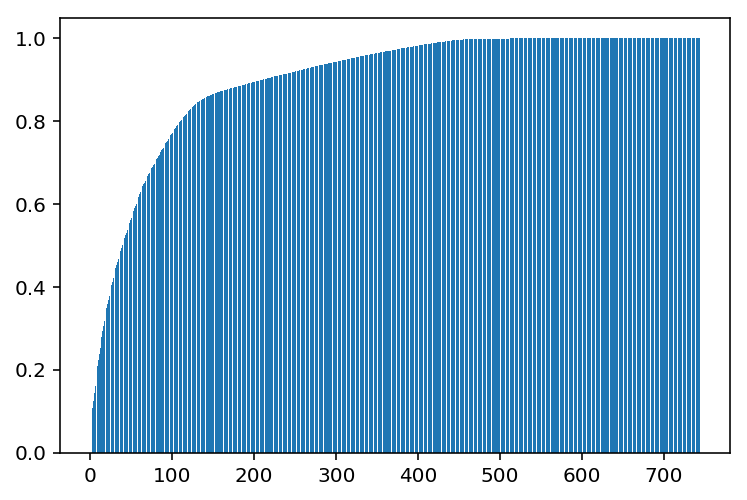

In [146]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
components = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_ + 1)
plt.bar(x_axis[:-1], pca.explained_variance_ratio_.cumsum()[:-1])

In [136]:
dfc = pd.DataFrame(data=pca.components_, columns=X_train.columns).T
dfc[0].sort_values().head(10), dfc[0].sort_values().tail(10)

(dropoff_month_5            -0.243319
 dropoff_month_10           -0.224218
 dropoff_month_12           -0.071680
 drop_off_week_of_year_18   -0.064960
 drop_off_week_of_year_21   -0.061273
 drop_off_week_of_year_42   -0.060073
 dropoff_month_3            -0.059956
 drop_off_week_of_year_20   -0.058389
 dropoff_month_9            -0.054681
 drop_off_week_of_year_43   -0.051912
 Name: 0, dtype: float64, dropoff_day_of_year_180     0.044352
 dropoff_day_of_year_159     0.044943
 dropoff_day_of_year_176     0.047338
 dropoff_hour_15             0.063749
 drop_off_week_of_year_22    0.078345
 drop_off_week_of_year_26    0.146219
 drop_off_week_of_year_24    0.151398
 drop_off_week_of_year_25    0.206841
 drop_off_week_of_year_23    0.221005
 dropoff_month_6             0.809696
 Name: 0, dtype: float64)

<BarContainer object of 743 artists>

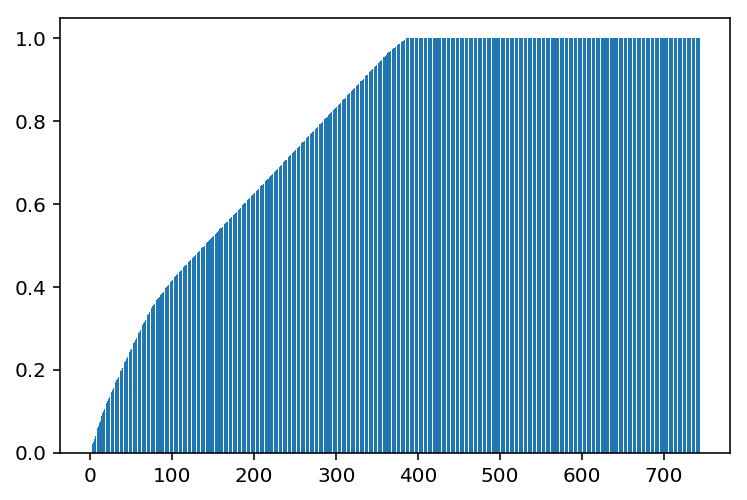

In [101]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_scaled)
components = pd.DataFrame(pca.transform(X_train_scaled))
x_axis = np.arange(1, pca.n_components_ + 1)
plt.bar(x_axis[:-1], pca.explained_variance_ratio_.cumsum()[:-1])

In [71]:
n_ests, mae_train_scores, mae_test_scores = [], [], []
for n in range(100, 1100, 100):
    t0 = time.time()
    m = do_model(n, X_train, X_test, y_train, y_test, sample_frac=.1)
    t = time.time() - t0
    
    n_ests.append(n)
    mae =  m['score']['mean_absolute_error']
    mae_train_scores.append(mae['train'])
    mae_test_scores.append(mae['test'])
    print('t={:.2f}s n={} mae_train={:.3f} mae_test={:.3f}'.format(
        t, n_ests[-1], mae_train_scores[-1], mae_test_scores[-1]))


t=1.84s n=100 mae_train=15.572 mae_test=17.730
t=3.24s n=200 mae_train=15.846 mae_test=17.864
t=4.76s n=300 mae_train=15.674 mae_test=17.690
t=6.29s n=400 mae_train=15.650 mae_test=17.660
t=7.77s n=500 mae_train=15.722 mae_test=17.798
t=9.43s n=600 mae_train=15.723 mae_test=17.792
t=11.45s n=700 mae_train=15.747 mae_test=17.807
t=13.23s n=800 mae_train=15.740 mae_test=17.780
t=14.79s n=900 mae_train=15.781 mae_test=17.822
t=16.55s n=1000 mae_train=15.784 mae_test=17.800


In [25]:
#t=368.20s n=10 mae_train=14.911 mae_test=15.785
#t=918.00s n=25 mae_train=14.829 mae_test=15.691
#t=1787.67s n=50 mae_train=14.752 mae_test=15.607
#t=3592.44s n=100 mae_train=14.735 mae_test=15.593
#t=8995.18s n=250 mae_train=14.718 mae_test=15.579

In [ ]:
from glob import glob
for f in glob('forest-*.pickle.gz'):
    m = pd.read_pickle(f)
    y_train_pred = m['forest'].predict(X_train)
    y_test_pred = m['forest'].predict(X_test)
    mae = m['score']['mean_absolute_error']
    print('n={} mae_train={:.3f} mae_test={:.3f}'.format(
        m['n_estimators'], mae['train'], mae['test']))

In [ ]:
m = pd.read_pickle('forest_n_ests=10.pickle.gz')

In [ ]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print("MAE train: {:.3f} test: {:.3f} ".format(mae_train, mae_test))

# Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression(normalize=True)

In [23]:
%time slr.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def display_metric(name, metric, y_train, y_train_pred, y_test, y_test_pred):
    print('train: {:.3f}, test: {:.3f}'.format(metric(y_train, y_train_pred), metric(y_test, y_test_pred)))

In [ ]:
display_metric('MAE', mean_absolute_error, y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
display_metric('MSE', mean_squared_error, y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
slr.score(X_train, y_train),slr.score(X_test, y_test)

In [ ]:
slr.coef_.max()

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [ ]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolors='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolors='white', label='Test data')
plt.xlabel('Predicted trip duration')
plt.ylabel('Residuals')
plt.legend()

In [ ]:
y_train.shape, y_train_pred.shape,y_test.shape, y_test_pred.shape

In [ ]:
from sklearn.metrics import mean_squared_error
print("MSE train: {:.3f}, test: {:.3f}".format(mean_squared_error(y_train, y_train_pred),
                                              mean_squared_error(y_test, y_test_pred)))

# RANSAC Regressor

In [ ]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=10,
                         loss='absolute_loss', residual_threshold=15.0, random_state=0)

In [ ]:
%time ransac.fit(X, y)

In [ ]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)

# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
def random_forest_training(n, X_train, y_train, X_test, y_test):
    forest = RandomForestRegressor(n_estimators=n, criterion='mse', random_state=1, n_jobs=5)
    forest.fit(X_train, y_train)
    y_train_pred = forest.predict(X_train)
    y_test_pred = forest.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    return mae_train, mae_test


In [ ]:
X, y = get_sampled_X_y(df, frac=0.01)
X_train, X_test, y_train, y_test = split(X, y)

In [ ]:
print(random_forest_training(2 , X_train, y_train, X_test, y_test))

In [ ]:
from sklearn.metrics import 
pars = [1,2,10,20,50,100,200,500,100,1000]
scores = pd.DataFrame()
for p in pars:
    t0 = time.time()
    mae_train, mae_test = random_forest_training(p, X_train, y_train, X_test, y_test)
    scores.loc[p,'mae_train'] = mae_train
    scores.loc[p,'mae_test'] = mae_test
    t = time.time() - t0
#    print("{} mae train: {:.3f} mae test: {:.3f} time: {:.3f}s".format(p, mae_train, mae_test, t))
    print("{} rmse train: {:.3f} mae test: {:.3f} time: {:.3f}s".format(p, mae_train, mae_test, t))

In [ ]:
scores.plot()

In [ ]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolors='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolors='white', label='Test data')
plt.xlabel('Predicted trip duration')
plt.ylabel('Residuals')
plt.legend()